# Enhanced cohort analysis results

We collect and inspect the results from the enhanced cohorrt analysis

1. [Loading modules](#Loading-modules)
2. [Loading the result table](#Loading-the-result-table)
3. [Analysis of results](#Analysis-of-results)
    * [List of analyzed campaigns](#List-of-analyzed-campaigns)
    * [Overall volumes and uplift](#Overall-volumes-and-uplift)
    * [Selected features](#Selected-features)
        * [Overall](#Overall)
        * [By product](#By-product)
4. [Rules analysis](#Rules-analysis)

## Loading modules

In [23]:
import numpy as np
import pandas as pd

import logging
import os
import gcsfs
import time
import datetime
from google.cloud import bigquery

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Loading the result table

In [2]:
PROJECT_ID_1 = 'skyuk-uk-decis-models-01-dev'
DATASET_ID_1 = 'test_and_learn'
TABLE_ID = 'full_campaign_dry_run_get_more_2'

In [3]:
bq = bigquery.Client()
query = """
        SELECT *
        from `{}.{}.{}`
        """.format(PROJECT_ID_1, DATASET_ID_1, TABLE_ID)

campaigns_frame = bq.query(query).to_dataframe()

In [4]:
campaigns_frame.head()

,L1_programme,L2_Campaign,CAMPAIGN_REPORTING_START_DATE,product,best_feature_1,best_feature_2,best_feature_3,best_feature_1_rule,best_feature_2_rule,best_feature_3_rule,treatment_sample_size,control_sample_size,treatment_conversion,control_conversion,uplift,p_value,significative,uplift_ranking,treatment_conversion_ranking
0,skyOptimusGetMore,QE Q2 Test,2019-04-20,QMS,MS_Active,SGE_Active,Movies_Active,No,No,Yes,225854,18485,0.005955,0.006167,-0.000212,0.719092,No,1,3
1,skyOptimusGetMore,QE Q2 Test,2019-04-20,QMS,MS_Active,SGE_Active,Movies_Active,Yes,,No,125214,9956,0.011572,0.012254,-0.000682,0.541302,No,2,6
2,skyOptimusGetMore,QE Q2 Test,2019-04-20,QMS,MS_Active,SGE_Active,Movies_Active,No,Yes,Yes,133982,10836,0.008098,0.009874,-0.001776,0.049002,Yes,3,4
3,skyOptimusGetMore,QE Q2 Test,2019-04-20,QMS,MS_Active,SGE_Active,Movies_Active,Yes,Yes,Yes,209586,16900,0.013011,0.014793,-0.001782,0.050447,No,4,7
4,skyOptimusGetMore,QE Q2 Test,2019-04-20,QMS,MS_Active,SGE_Active,Movies_Active,No,No,No,217473,16653,0.004212,0.006245,-0.002033,0.000123,Yes,5,1


## Analysis of results

### List of analyzed campaigns

In [5]:
campaigns_frame[['L1_programme','L2_Campaign','CAMPAIGN_REPORTING_START_DATE']].drop_duplicates()

,L1_programme,L2_Campaign,CAMPAIGN_REPORTING_START_DATE
0,skyOptimusGetMore,QE Q2 Test,2019-04-20
7,skyOptimusGetMore,QE Q2 Loyalty,2019-05-04
15,skyOptimusGetMore,Sports F1 Phase 2,2019-04-23
36,skyOptimusGetMore,Sports Cricket,2019-05-25
88,skyOptimusGetMore,Cinema Half Term Free Trial,2019-06-20
106,skyOptimusGetMore,Q3 QE Tactical VIP,2019-07-05
114,skyOptimusGetMore,ALC UK Pre Season,2019-06-20
129,skyOptimusGetMore,Mobile Join&Recontract,2019-06-02
185,skyOptimusGetMore,Summer Cinema,2019-07-15
190,skyOptimusGetMore,Sports The Open,2019-07-12


In [6]:
campaigns_frame.drop_duplicates(subset=['treatment_sample_size','control_sample_size'],inplace=True)

In [84]:
campaigns_frame[['L1_programme','L2_Campaign','CAMPAIGN_REPORTING_START_DATE']].drop_duplicates().shape

(29, 3)

### Overall volumes and uplift

In [24]:
grouped = campaigns_frame.groupby(by=['L1_programme','L2_Campaign','CAMPAIGN_REPORTING_START_DATE'])[['treatment_sample_size',
                                                                                                      'control_sample_size',
                                                                                                      'treatment_conversion',
                                                                                                      'control_conversion',
                                                                                                      'uplift']].agg(lambda x:list(x))

In [25]:
grouped['treatment_vol'] = grouped.treatment_sample_size.apply(lambda row: np.sum(row))
grouped['control_vol'] =grouped.control_sample_size.apply(lambda row: np.sum(row))

grouped['treatment_tot_conversion'] = grouped.apply(lambda row: np.average(row['treatment_conversion'],weights=row['treatment_sample_size']),axis=1)
grouped['control_tot_conversion'] = grouped.apply(lambda row: np.average(row['control_conversion'],weights=row['control_sample_size']),axis=1)
grouped['uplift_spread'] = grouped.apply(lambda row: np.std(row['uplift']),axis=1)

In [26]:
grouped['tot_uplift'] = grouped['treatment_tot_conversion']-grouped['control_tot_conversion']
grouped.sort_values(by=['tot_uplift'],ascending=False,inplace=True)
grouped = grouped[['treatment_vol','control_vol','treatment_tot_conversion','control_tot_conversion','tot_uplift','uplift_spread']].reset_index()
grouped.head()

,L1_programme,L2_Campaign,CAMPAIGN_REPORTING_START_DATE,treatment_vol,control_vol,treatment_tot_conversion,control_tot_conversion,tot_uplift,uplift_spread
0,skyOptimusGetMore,Cinema Half Term Free Trial,2019-06-20,311341,46128,0.055123,0.001864,0.053258,0.024371
1,skyOptimusGetMore,Sports Start of Season,2019-07-22,731765,21607,0.016595,0.009025,0.007571,0.011246
2,skyOptimusGetMore,Sports F1 Phase 2,2019-04-23,532968,109754,0.012958,0.008610,0.004347,0.004219
3,skyOptimusGetMore,QE Q2 Loyalty,2019-05-04,406584,648,0.007408,0.003086,0.004322,0.004706
4,skyOptimusGetMore,Cinema Range,2019-01-25,945438,77279,0.009890,0.005707,0.004183,0.002397


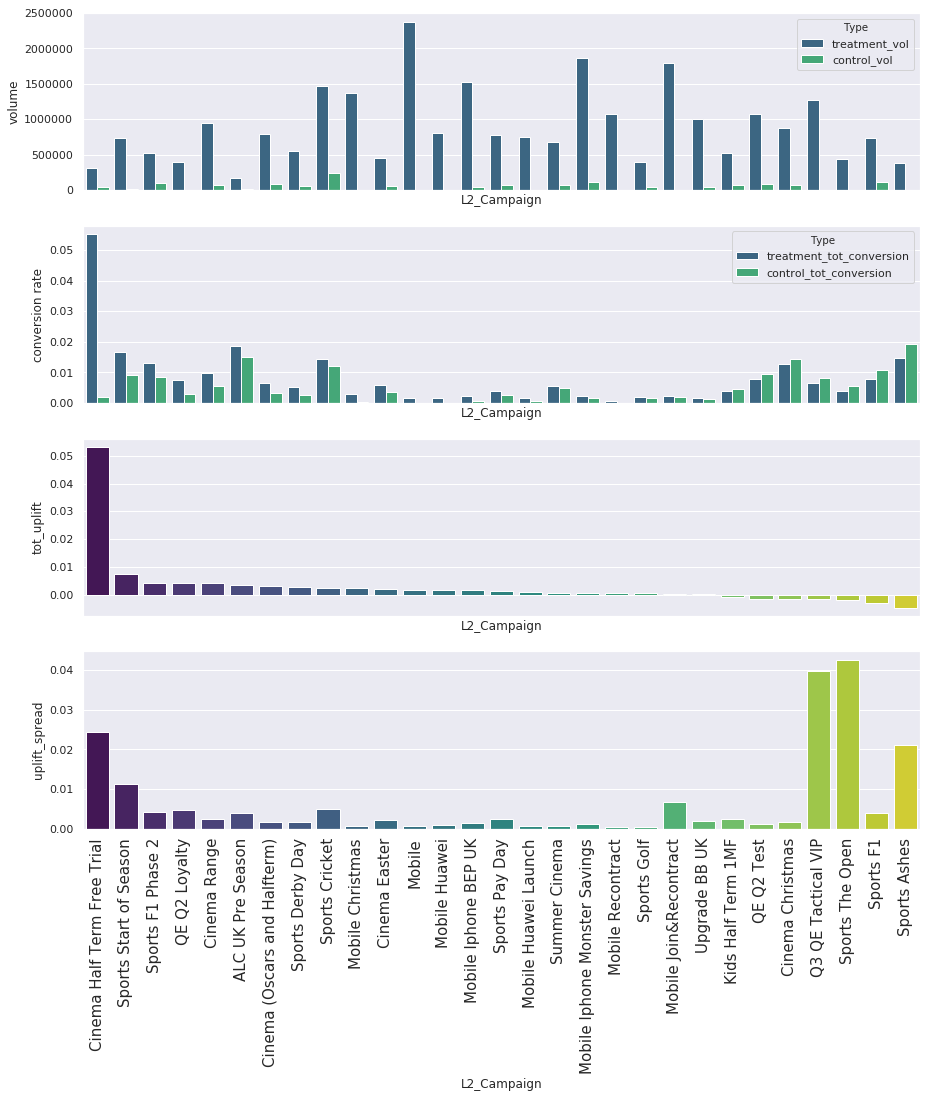

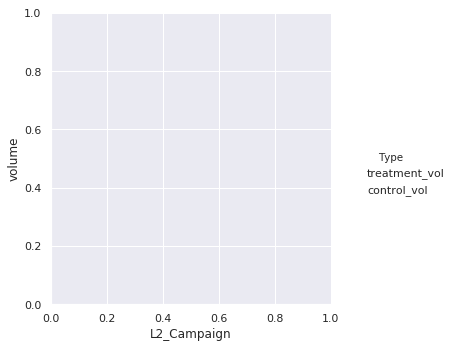

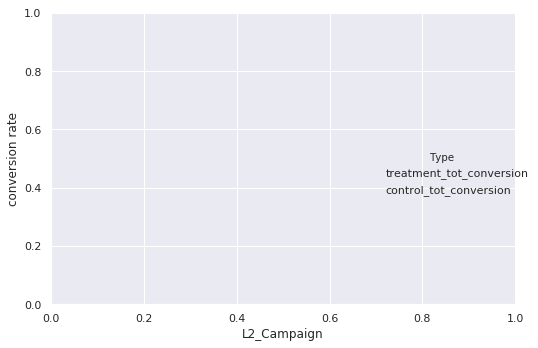

In [27]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,15),sharex=True)
plt.xticks(rotation=90,fontsize=15)

tmp = grouped[['L2_Campaign','treatment_vol','control_vol']].set_index('L2_Campaign').reset_index()
df = pd.melt(tmp, id_vars='L2_Campaign', var_name="Type", value_name="volume")
sns.catplot(x="L2_Campaign", y="volume", hue="Type", data=df,
                 kind="bar", palette="viridis",ax=ax1)

tmp = grouped[['L2_Campaign','treatment_tot_conversion','control_tot_conversion']].set_index('L2_Campaign').reset_index()
df = pd.melt(tmp, id_vars='L2_Campaign', var_name="Type", value_name="conversion rate")
sns.catplot(x="L2_Campaign", y="conversion rate", hue="Type", data=df,
                 kind="bar", palette="viridis",ax=ax2)

sns.barplot(x='L2_Campaign',y='tot_uplift',data=grouped,ax=ax3,palette='viridis')
sns.barplot(x='L2_Campaign',y='uplift_spread',data=grouped,ax=ax4,palette='viridis')

plt.tight_layout()
plt.show()

### Selected features

In [77]:
grouped = campaigns_frame.groupby(by=['L1_programme','L2_Campaign','CAMPAIGN_REPORTING_START_DATE'])[['best_feature_1', 'best_feature_2', 'best_feature_3']].agg(lambda x: np.unique(list(x))[0])

#### Overall

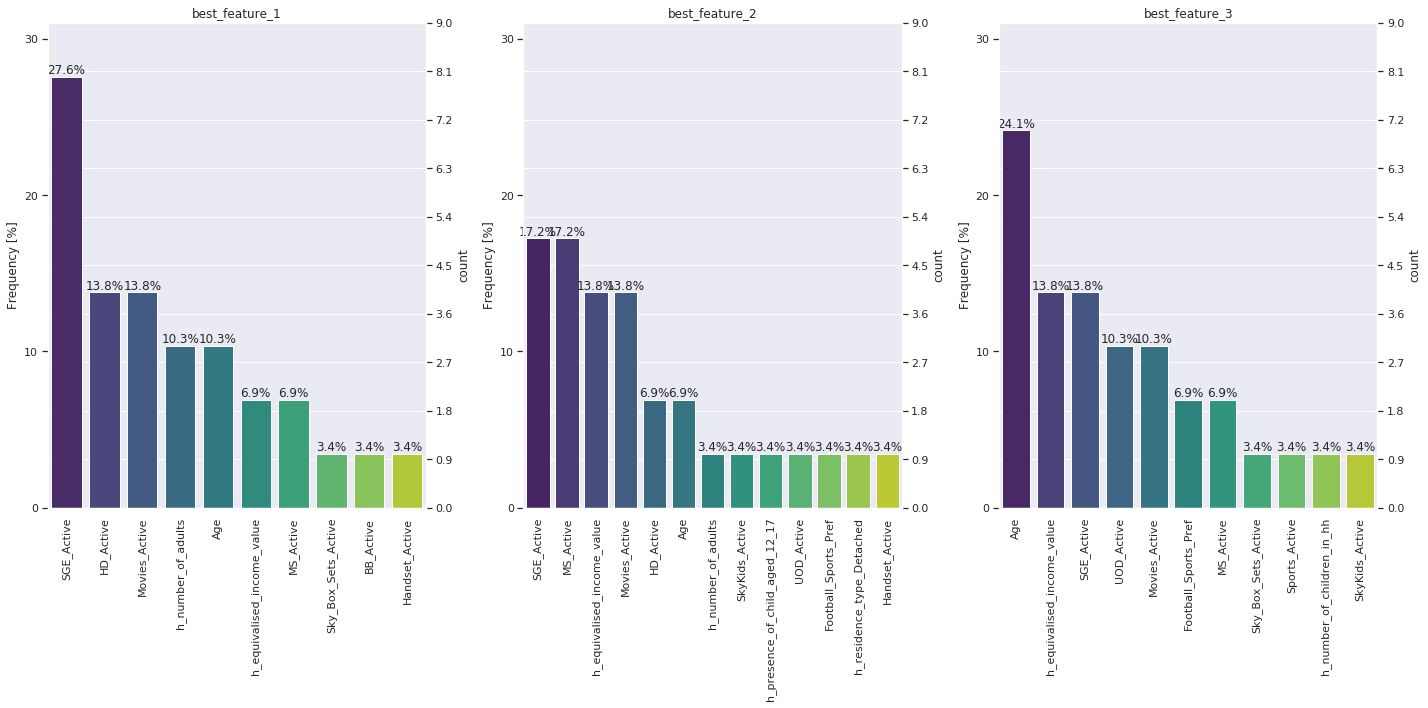

In [78]:
import matplotlib.ticker as ticker
from matplotlib import cm
sns.set(style="darkgrid")

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
ncount=len(grouped)

for feature,ax in zip(['best_feature_1','best_feature_2','best_feature_3'],
                      [ax1, ax2, ax3]):
    sort_index = grouped[feature].value_counts().sort_values(ascending=False).index
    grouped[feature] = grouped[feature].astype('str')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(feature)
    sns.countplot(grouped[feature],ax=ax,order=sort_index,palette = 'viridis')
    ax.set_xlabel(None)
    ax2=ax.twinx()
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
        
    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0,100-2000/ncount)
    ax.set_ylim(0,ncount-20)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

plt.tight_layout()
plt.show()

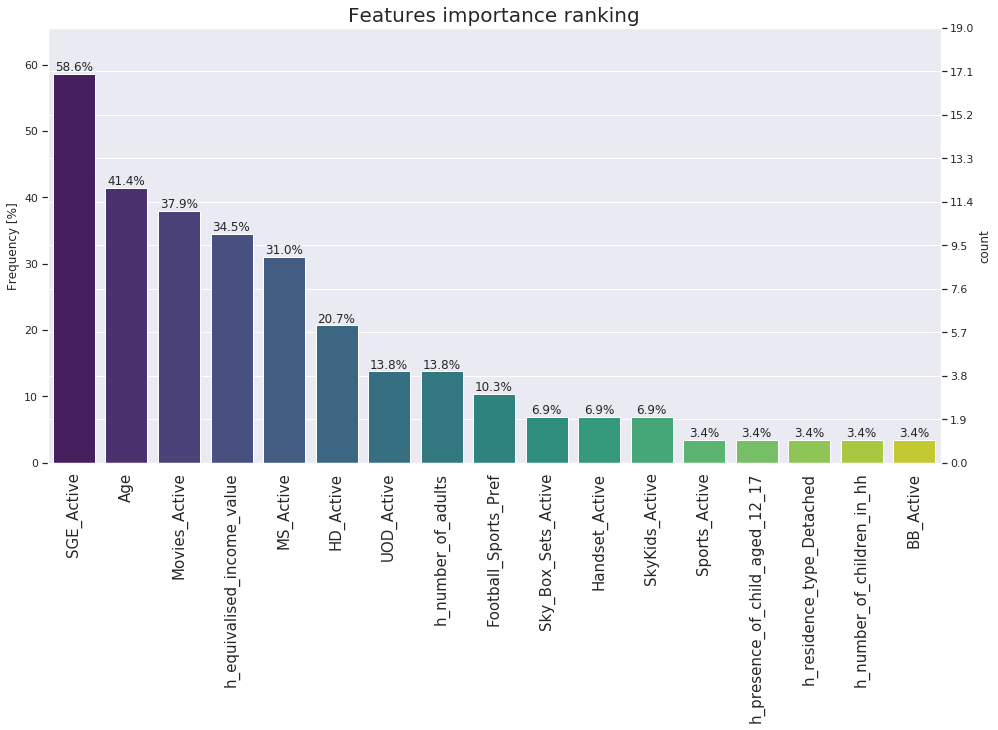

In [80]:
plt.figure(figsize=(16,8))
total = pd.DataFrame({'all_features':grouped.best_feature_1.values.tolist()+grouped.best_feature_2.values.tolist()+grouped.best_feature_3.values.tolist()})
sort_index = total['all_features'].value_counts().sort_values(ascending=False).index
plt.xticks(rotation=90,fontsize=15)
ax = sns.countplot(total['all_features'],palette='viridis',order=sort_index)
ax.tick_params(axis='x', rotation=90)
ax.set_title('Features importance ranking',fontsize=20)
ax.set_xlabel(None)
ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100-1000/ncount)
ax.set_ylim(0,ncount-10)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

plt.show()





#### By product

In [81]:
grouped = campaigns_frame.groupby(by=['L1_programme','L2_Campaign','CAMPAIGN_REPORTING_START_DATE'])[['best_feature_1', 'best_feature_2', 'best_feature_3','product']].agg(lambda x: np.unique(list(x))[0])

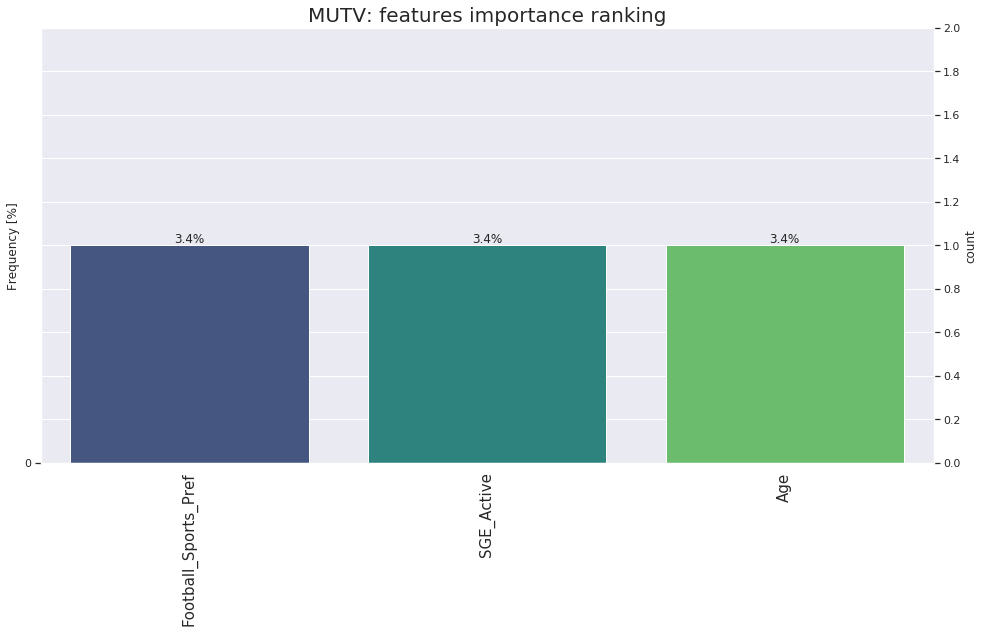

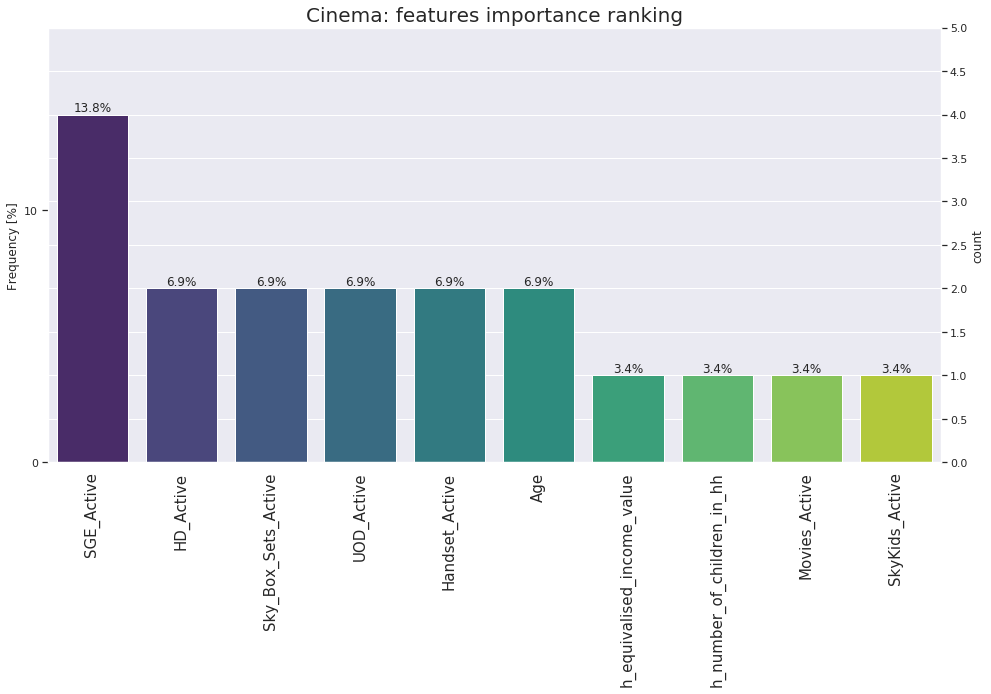

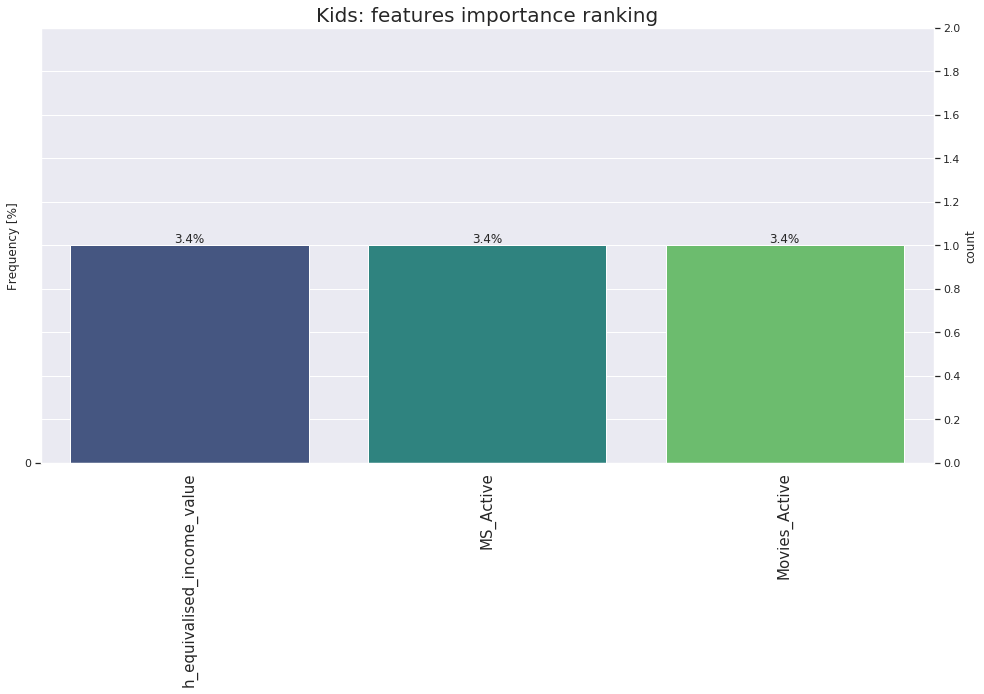

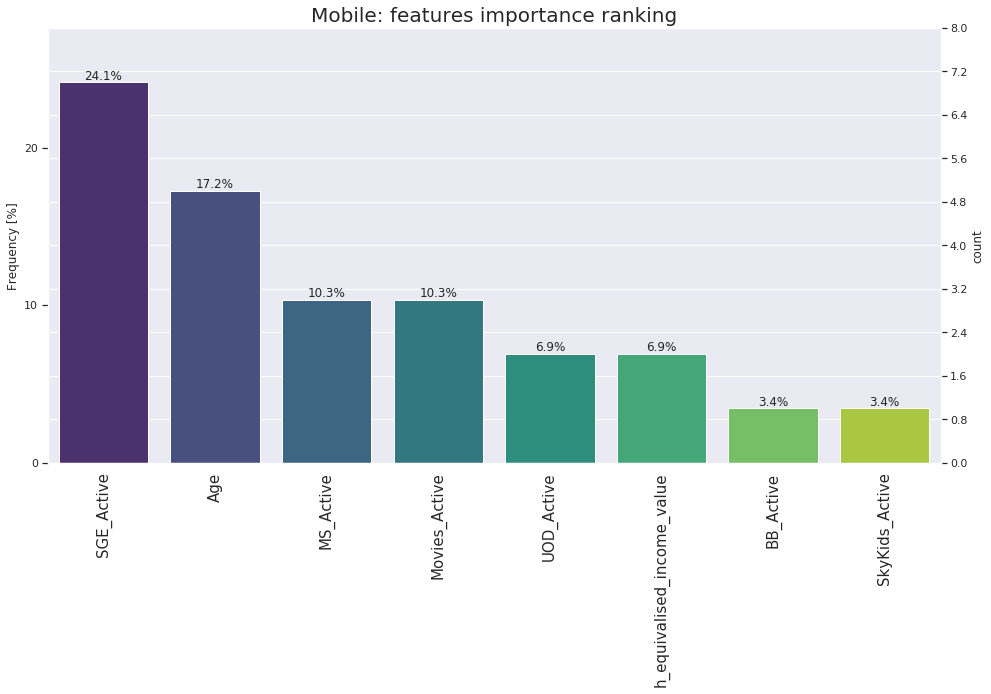

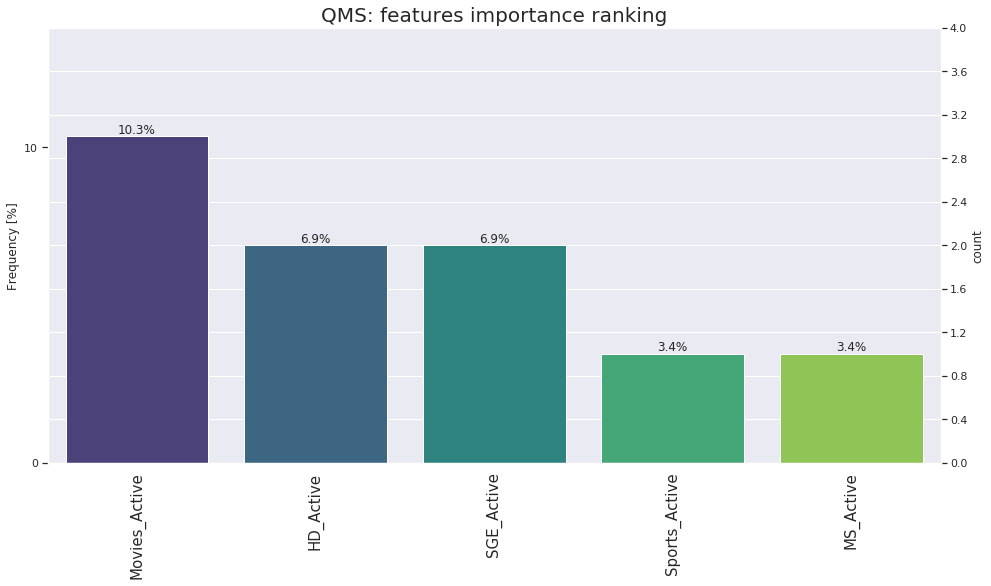

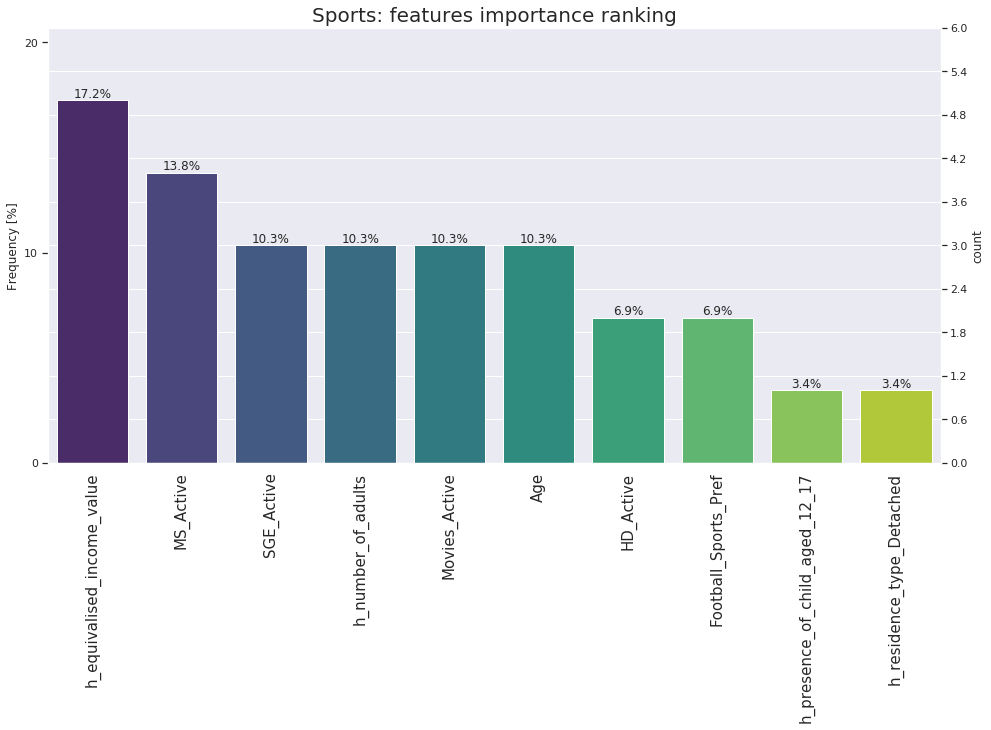

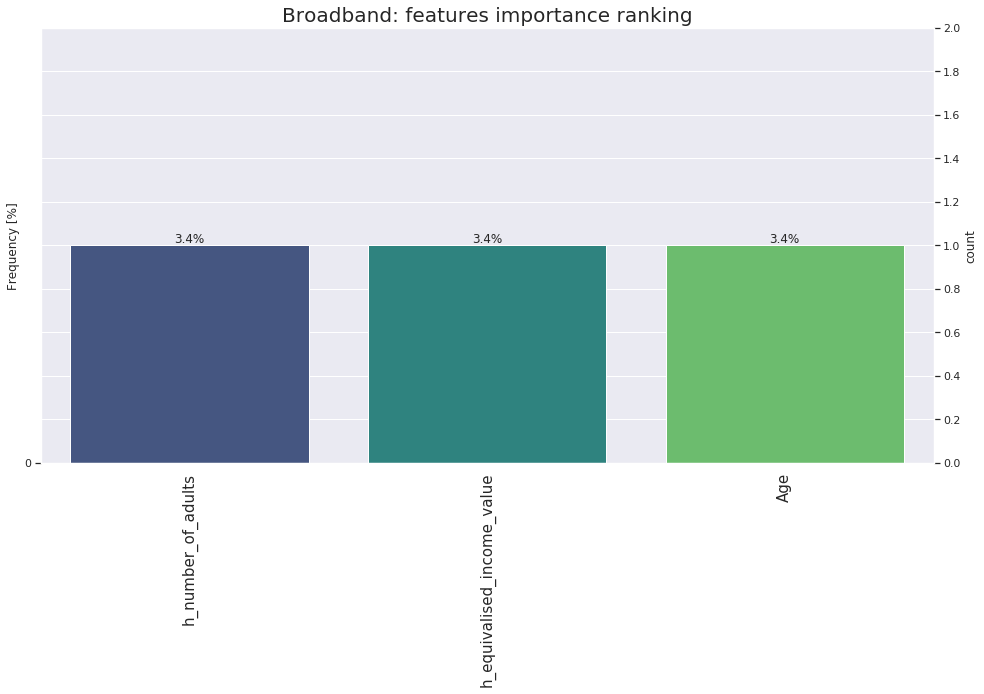

In [82]:
for product in pd.unique(grouped['product']):
    sub_table = grouped[grouped['product']==product]
    
    plt.figure(figsize=(16,8))
    total = pd.DataFrame({'all_features':sub_table.best_feature_1.values.tolist()+sub_table.best_feature_2.values.tolist()+sub_table.best_feature_3.values.tolist()})
    plt.xticks(rotation=90)
    sort_index = total['all_features'].value_counts().sort_values(ascending=False).index
    plt.xticks(rotation=90,fontsize=15)
    ax = sns.countplot(total['all_features'],palette='viridis',order=sort_index)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('{}: features importance ranking'.format(product.split(' ')[0]),fontsize=20)
    ax.set_xlabel(None)
    ax2=ax.twinx()
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0,(total['all_features'].value_counts().max()+1)*100/ncount)
    ax.set_ylim(0,total['all_features'].value_counts().max()+1)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

    plt.show()
    print('\n\n\n\n')

## Rules analysis

In [38]:
pd.unique(campaigns_frame.L2_Campaign)

array(['QE Q2 Test', 'QE Q2 Loyalty', 'Sports F1 Phase 2',
       'Sports Cricket', 'Cinema Half Term Free Trial',
       'Q3 QE Tactical VIP', 'ALC UK Pre Season',
       'Mobile Join&Recontract', 'Summer Cinema', 'Sports The Open',
       'Sports Ashes', 'Sports Start of Season', 'Mobile',
       'Sports Derby Day', 'Sports F1', 'Mobile Huawei',
       'Mobile Iphone Monster Savings', 'Cinema Range', 'Sports Pay Day',
       'Cinema Christmas', 'Mobile Christmas', 'Upgrade BB UK',
       'Cinema (Oscars and Halfterm)', 'Mobile Iphone BEP UK',
       'Mobile Recontract', 'Cinema Easter', 'Sports Golf',
       'Mobile Huawei Launch', 'Kids Half Term 1MF'], dtype=object)

### Cinema Half Term Free Trial

In [92]:
sub_table = campaigns_frame[campaigns_frame.L2_Campaign=='Cinema Half Term Free Trial'].copy()
dicto = {}
feato = []
for feature in ['best_feature_1','best_feature_2','best_feature_3']:
    dicto[feature+'_rule'] = pd.unique(sub_table[feature])[0]
    feato.append(pd.unique(sub_table[feature])[0])
sub_table.rename(columns=dicto,inplace=True)
sub_table.sort_values(by=['uplift'],ascending=False,inplace=True)
sub_table.reset_index(inplace=True)
sub_table[feato+['treatment_sample_size','control_sample_size','uplift','significative']][-5:]

,SGE_Active,Handset_Active,Age,treatment_sample_size,control_sample_size,uplift,significative
13,No,,60 < X <= 66,7787,1331,0.032272,Yes
14,No,,X <= 30,9909,1956,0.031554,Yes
15,No,,65 < X <= 70,6054,1119,0.029995,Yes
16,Yes,No,X > 76,6761,886,0.025456,Yes
17,No,,X > 70,9550,1721,0.023770,Yes


In [68]:
sub_table[['treatment_conversion','uplift']].corr()

,treatment_conversion,uplift
treatment_conversion,1.000000,0.998959
uplift,0.998959,1.000000


In [87]:
sub_table.shape

(18, 19)

### 'Sports Start of Season'

In [69]:
sub_table = campaigns_frame[campaigns_frame.L2_Campaign=='Sports Start of Season'].copy()
dicto = {}
feato = []
for feature in ['best_feature_1','best_feature_2','best_feature_3']:
    dicto[feature+'_rule'] = pd.unique(sub_table[feature])[0]
    feato.append(pd.unique(sub_table[feature])[0])
sub_table.rename(columns=dicto,inplace=True)
sub_table.sort_values(by=['uplift'],ascending=False,inplace=True)
sub_table[feato+['treatment_sample_size','control_sample_size','treatment_conversion','control_conversion','uplift','p_value','significative']]

,SGE_Active,MS_Active,Football_Sports_Pref,treatment_sample_size,control_sample_size,treatment_conversion,control_conversion,uplift,p_value,significative
219,,Yes,> 0,8850,301,0.052316,0.013289,0.039027,2.479784e-03,Yes
220,Yes,No,> 0,5250,174,0.040190,0.022989,0.017202,2.525473e-01,No
221,No,No,> 0,9271,286,0.034301,0.020979,0.013321,2.201717e-01,No
222,Yes,Yes,<= 0,213841,6717,0.020642,0.009975,0.010667,1.050692e-09,Yes
223,Yes,No,<= 0,103288,3431,0.017379,0.010201,0.007177,1.442834e-03,Yes
224,No,,<= 0,391265,10698,0.012633,0.007385,0.005249,1.420209e-06,Yes


In [70]:
sub_table[['treatment_conversion','uplift']].corr()

,treatment_conversion,uplift
treatment_conversion,1.000000,0.914804
uplift,0.914804,1.000000


### Mobile Iphone BEP UK

In [71]:
sub_table = campaigns_frame[campaigns_frame.L2_Campaign== 'Mobile Iphone BEP UK'].copy()
dicto = {}
feato = []
for feature in ['best_feature_1','best_feature_2','best_feature_3']:
    dicto[feature+'_rule'] = pd.unique(sub_table[feature])[0]
    feato.append(pd.unique(sub_table[feature])[0])
sub_table.rename(columns=dicto,inplace=True)
sub_table.sort_values(by=['uplift'],ascending=False,inplace=True)
sub_table[feato+['treatment_sample_size','control_sample_size','treatment_conversion','control_conversion','uplift','p_value','significative']]

,SGE_Active,MS_Active,Age,treatment_sample_size,control_sample_size,treatment_conversion,control_conversion,uplift,p_value,significative
442,Yes,,40 < X <= 50,226707,9116,0.003599,0.000439,0.003161,4.999984e-07,Yes
434,No,Yes,<= 66,7177,236,0.002647,0.000000,0.002647,4.286866e-01,No
443,Yes,Yes,X <= 30,32598,1225,0.003221,0.000816,0.002405,1.393312e-01,No
444,Yes,Yes,65 < X <= 70,61477,1976,0.002310,0.000000,0.002310,3.245282e-02,Yes
445,Yes,Yes,60 < X <= 66,73619,2593,0.002662,0.000386,0.002277,2.482955e-02,Yes
446,Yes,,30 < X <= 40,154187,6675,0.003450,0.001348,0.002102,3.682157e-03,Yes
447,Yes,No,60 < X <= 66,7200,252,0.002083,0.000000,0.002083,4.682685e-01,No
448,Yes,Yes,70 < X <= 76,48282,1375,0.002030,0.000000,0.002030,9.447539e-02,No
449,Yes,No,X <= 30,10128,398,0.001975,0.000000,0.001975,3.748765e-01,No
450,Yes,Yes,55 < X <= 60,98875,3737,0.002731,0.000803,0.001928,2.470891e-02,Yes


In [72]:
sub_table[['treatment_conversion','uplift']].corr()

,treatment_conversion,uplift
treatment_conversion,1.00000,0.36623
uplift,0.36623,1.00000


In [73]:
sub_table = campaigns_frame[campaigns_frame.L2_Campaign== 'Sports The Open'].copy()
dicto = {}
feato = []
for feature in ['best_feature_1','best_feature_2','best_feature_3']:
    dicto[feature+'_rule'] = pd.unique(sub_table[feature])[0]
    feato.append(pd.unique(sub_table[feature])[0])
sub_table.rename(columns=dicto,inplace=True)
sub_table.sort_values(by=['uplift'],ascending=False,inplace=True)
sub_table[feato+['treatment_sample_size','control_sample_size','treatment_conversion','control_conversion','uplift','p_value','significative']]

,Age,h_residence_type_Detached,h_equivalised_income_value,treatment_sample_size,control_sample_size,treatment_conversion,control_conversion,uplift,p_value,significative
190,> 60,Yes,28650 < X <= 40850,6041,3,0.008773,0.000000,0.008773,8.705571e-01,No
191,> 60,Yes,40850 < X <= 55950,5556,5,0.007559,0.000000,0.007559,8.452733e-01,No
192,45 < X <= 60,Yes,29550 < X <= 34350,5121,4,0.007225,0.000000,0.007225,8.645235e-01,No
193,> 60,Yes,X > 55950,5034,3,0.006754,0.000000,0.006754,8.864258e-01,No
194,45 < X <= 60,Yes,X <= 29550,12992,17,0.005542,0.000000,0.005542,7.582403e-01,No
195,<= 60,Yes,38450 < X <= 44250,9004,8,0.005442,0.000000,0.005442,8.342742e-01,No
196,X > 70,No,11850 < X <= 39350,22281,26,0.005386,0.000000,0.005386,7.074999e-01,No
197,> 60,No,X > 46750,7922,8,0.004923,0.000000,0.004923,8.423067e-01,No
198,> 60,Yes,<= 28650,7923,10,0.004922,0.000000,0.004922,8.239934e-01,No
199,X <= 46,Yes,25550 < X <= 34350,6886,4,0.004792,0.000000,0.004792,8.896192e-01,No


In [74]:
sub_table[['treatment_conversion','uplift']].corr()

,treatment_conversion,uplift
treatment_conversion,1.000000,-0.088335
uplift,-0.088335,1.000000


In [75]:
sub_table = campaigns_frame[campaigns_frame.L2_Campaign== 'Mobile Huawei Launch'].copy()
dicto = {}
feato = []
for feature in ['best_feature_1','best_feature_2','best_feature_3']:
    dicto[feature+'_rule'] = pd.unique(sub_table[feature])[0]
    feato.append(pd.unique(sub_table[feature])[0])
sub_table.rename(columns=dicto,inplace=True)
sub_table.sort_values(by=['uplift'],ascending=False,inplace=True)
sub_table[feato+['treatment_sample_size','control_sample_size','treatment_conversion','control_conversion','uplift','p_value','significative']]

,BB_Active,MS_Active,SGE_Active,treatment_sample_size,control_sample_size,treatment_conversion,control_conversion,uplift,p_value,significative
494,Yes,No,Yes,57371,278,0.002475,0.000000,0.002475,0.406239,No
495,Yes,Yes,Yes,157623,1135,0.003401,0.002643,0.000757,0.662064,No
496,No,Yes,,131141,1887,0.001273,0.000530,0.000743,0.366563,No
497,No,No,Yes,42841,446,0.000700,0.000000,0.000700,0.576129,No
498,No,No,No,120327,1873,0.000540,0.000000,0.000540,0.314347,No
499,Yes,,No,241362,1541,0.001587,0.001298,0.000289,0.776218,No


In [76]:
sub_table[['treatment_conversion','uplift']].corr()

,treatment_conversion,uplift
treatment_conversion,1.000000,0.403711
uplift,0.403711,1.000000


## Further analysis of volumes

In [150]:
bq = bigquery.Client()
query = """
with tmp as (
SELECT L2_Campaign, L3_Journey, account_number from   `skyuk-uk-decis-models-01-dev.test_and_learn.optimus_base_clean`
 WHERE
   (((cell_type = 'Treatment')
          AND (control_type2='Campaign control'))
      AND (L1_programme = 'skyOptimusGetMore'))
group by   L2_Campaign, L3_Journey, account_number
)
SELECT L2_Campaign, L3_Journey, 
        count(account_number) as count
from   tmp

  group by   L2_Campaign, L3_Journey 
        """
analysis_frame_treat = bq.query(query).to_dataframe()
analysis_frame_treat.sort_values(by=['L2_Campaign'],inplace=True)

In [151]:
bq = bigquery.Client()
query = """
with tmp as (
SELECT L2_Campaign, L3_Journey, account_number from   `skyuk-uk-decis-models-01-dev.test_and_learn.optimus_base_clean`
 WHERE
   (((cell_type != 'Treatment')
          AND (control_type2='Campaign control'))
      AND (L1_programme = 'skyOptimusGetMore'))
group by   L2_Campaign, L3_Journey, account_number
)
SELECT L2_Campaign, L3_Journey, 
        count(account_number) as count
from   tmp

  group by   L2_Campaign, L3_Journey 
        """
analysis_frame_ctr = bq.query(query).to_dataframe()
analysis_frame_ctr.sort_values(by=['L2_Campaign'],inplace=True)

In [152]:
analysis_frame_treat['count'].describe()

count    1.420000e+02
mean     4.050450e+05
std      4.313448e+05
min      3.000000e+00
25%      9.950375e+04
50%      2.401250e+05
75%      5.609950e+05
max      2.197019e+06
Name: count, dtype: float64

In [153]:
analysis_frame_ctr['count'].describe()

count       100.000000
mean      31087.300000
std       37704.390319
min          10.000000
25%        5384.000000
50%       12352.000000
75%       50379.500000
max      203125.000000
Name: count, dtype: float64

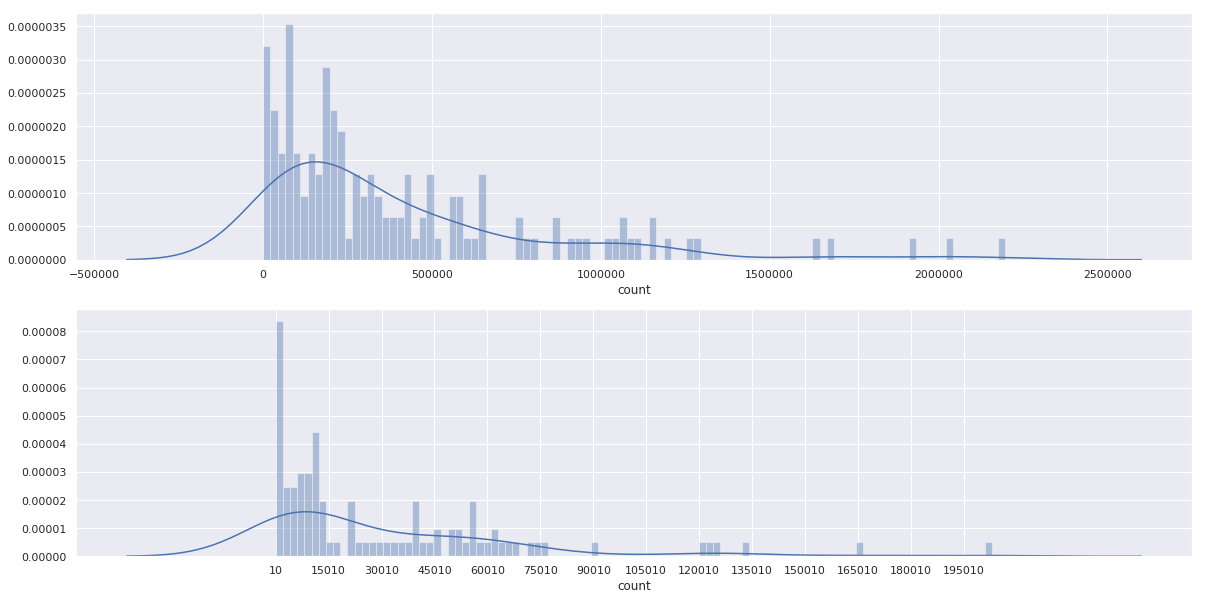

In [154]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,10))
sns.distplot(analysis_frame_treat['count'],bins=100, ax=ax1)
ax2.xaxis.set_ticks(np.arange(min(analysis_frame_ctr['count']), max(analysis_frame_ctr['count'])+1, 15000))
sns.distplot(analysis_frame_ctr['count'],bins=100, ax=ax2)
plt.show()

In [160]:
bq = bigquery.Client()
query = """
with tmp as (
SELECT L2_Campaign, L3_Journey, L4_Step, account_number from   `skyuk-uk-decis-models-01-dev.test_and_learn.optimus_base_clean`
 WHERE
   (((cell_type = 'Treatment')
          AND (control_type2='Campaign control'))
      AND (L1_programme = 'skyOptimusGetMore'))
group by   L2_Campaign, L3_Journey, L4_Step, account_number
)
SELECT L2_Campaign, L3_Journey, L4_Step, 
        count(account_number) as count
from   tmp

  group by   L2_Campaign, L3_Journey, L4_Step
        """
analysis_frame_treat = bq.query(query).to_dataframe()
analysis_frame_treat.sort_values(by=['L2_Campaign'],inplace=True)

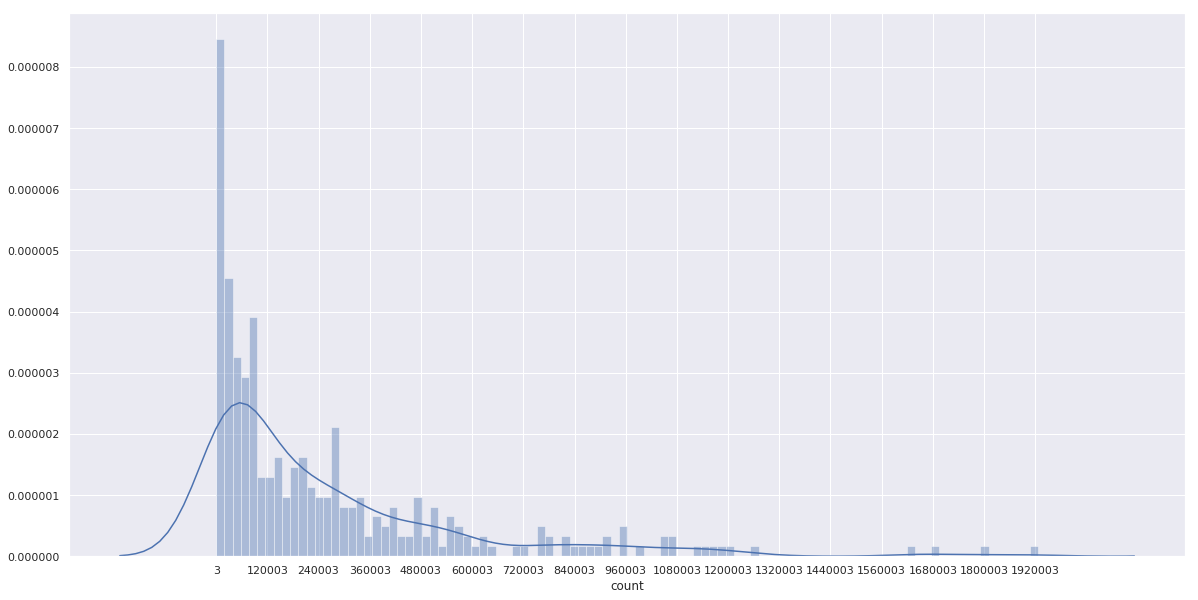

In [163]:
fig, (ax1) = plt.subplots(1,1,figsize=(20,10))
ax1.xaxis.set_ticks(np.arange(min(analysis_frame_treat['count']), max(analysis_frame_treat['count'])+1, 120000))
sns.distplot(analysis_frame_treat['count'],bins=100, ax=ax1)
plt.show()

In [129]:
len(np.arange(min(analysis_frame_treat['count']), max(analysis_frame_treat['count'])+1, 10000))

193